In [17]:
import torch
import torch.nn as nn
import torchvision as tv
import matplotlib.pyplot as plt

In [18]:
MNIST_dataset = tv.datasets.MNIST(root='./data', train=True, transform=tv.transforms.ToTensor(), download=True)
MNIST_loader = torch.utils.data.DataLoader(MNIST_dataset, batch_size=128, shuffle=True)

In [19]:
def preprocess_mnist(data):
    # torch.distibution.Bernoulli ONLY accepts boolean values as input. Converting input imgs to binary.
    data = torch.round(data)
    return data

In [20]:
class MnistEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(MnistEncoder, self).__init__()
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logsig2 = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x = self.dense1(x)
        x = torch.tanh(x)
        mu = self.mu(x)
        logsig2 = self.logsig2(x)
        return mu, torch.exp(logsig2)

In [21]:
class MnistDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(MnistDecoder, self).__init__()
        self.dense1 = nn.Linear(latent_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.dense1(x)
        x = torch.tanh(x)
        x = self.dense2(x)
        return torch.sigmoid(x)

In [22]:
class MnistVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(MnistVAE, self).__init__()
        self.latent_dimension = latent_dim
        self.encoder = MnistEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = MnistDecoder(latent_dim, hidden_dim, input_dim)
        
    def sample_latent(self, mu, sig2):
        z = torch.normal(torch.zeros_like(mu), torch.ones_like(sig2))
        return torch.sqrt(sig2)*z + mu

    def elbo_loss(self, sampled_z, mu, sig2, x, p):

        # log_q(z|x) logprobability of z under approximate posterior N(mu,sig)
        log_q = torch.distributions.Normal(mu, torch.sqrt(sig2)).log_prob(sampled_z).sum(dim=1)
        
        # log_p_z(z) log probability of z under prior
        z_mu = torch.FloatTensor([0]*self.latent_dimension).repeat(sampled_z.shape[0], 1)
        z_sigma = torch.FloatTensor([1]*self.latent_dimension).repeat(sampled_z.shape[0], 1)
        log_p_z = torch.distributions.Normal(z_mu, torch.sqrt(z_sigma)).log_prob(sampled_z).sum(dim=1)

        # log_p(x|z) - conditional probability of data given latents.
        log_p = torch.distributions.Bernoulli(p).log_prob(x).sum(1)
        
        # TODO: implement the ELBO loss using log_q, log_p_z and log_p
        elbo = torch.mean(log_p + log_p_z - log_q)
        return elbo

    def train(self, dataset, num_epochs):
        
        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        adam_optimizer = torch.optim.Adam(params)

        for epoch in range(num_epochs):
            for batch in MNIST_loader:
                img, _ = batch
                x_minibatch = img.view(-1, 784)
                x_minibatch = preprocess_mnist(x_minibatch)
                adam_optimizer.zero_grad()

                mu, sigma_square = self.encoder(x_minibatch)
                zs = self.sample_latent(mu, sigma_square)
                p = self.decoder(zs)
                elbo = self.elbo_loss(zs, mu, sigma_square, x_minibatch, p)
                total_loss = -elbo
                total_loss.backward()
                adam_optimizer.step()

            print("Epoch: " + str(epoch) + ", Loss:" + str(total_loss.item()))

    
    def visualize_data_space(self, img):
        img = img.view(-1, 784)
        mu, sigma_square = self.encoder(img)
        
        z = self.sample_latent(mu, sigma_square)

        # TODO: For each z, plot p(x|z)
        p = self.decoder(z)
        p = p.detach()
        x_samples = torch.bernoulli(p)

        fig, axs = plt.subplots(1, 2, figsize=(5, 10), dpi=100)

        img_dist = p.view(28, 28)
        img_sample = x_samples.view(28, 28)
        axs[0].imshow(img_dist)
        axs[1].imshow(img_sample)
        axs[0].axis('off')
        axs[1].axis('off')
        plt.tight_layout()
        plt.show()
        return
        
    def visualize_latent_space(self, imgs, labels):
        imgs = imgs.view(-1, 784)
        mu, _ = self.encoder(imgs)
        colors = ['red', 'blue', 'yellow', 'green', 'orange', 'purple', 'cyan', 'magenta', 'black', 'brown']
        fig, ax = plt.subplots(1, 1, figsize = (5, 5), dpi = 100)
        point_sets = []
        for i in range(len(colors)):
            inner_list = []
            for _ in range(mu.shape[1]):
                inner_list.append([])
            point_sets.append(inner_list)

        for i in range(mu.shape[0]):
            label = labels[i]
            point_sets[label][0].append(mu[i, 0].detach().numpy())
            point_sets[label][1].append(mu[i, 1].detach().numpy())
        
        for i in range(len(point_sets)):
            ax.scatter(point_sets[i][0], point_sets[i][1], color=colors[i], label=i)
        plt.legend()
        ax.set_xlabel(r"$\mu_1$")
        ax.set_ylabel(r"$\mu_2$")
        plt.show()


    @staticmethod
    def interpolate_mu(mua, mub, alpha = 0.5):
        return alpha*mua + (1-alpha)*mub


    def visualize_inter_class_interpolation(self, imgs, labels):
        N_data = imgs.shape[0]
        fig, axs = plt.subplots(1, 10, figsize=(20, 5), dpi=100)
        
        id_1 = torch.randint(0, N_data, (1,)).item()
        sample_1 = imgs[id_1, ...]
        label_1 = labels[id_1]
        while True:
            id_2 = torch.randint(0, N_data, (1,)).item()
            sample_2 = imgs[id_2, ...]
            label_2 = labels[id_2]
            if label_1 != label_2:
                break

        mu1, sigma1 = self.encoder(sample_1.view(-1, 784))
        mu2, sigma2 = self.encoder(sample_2.view(-1, 784))

        for i in range(10):
            z = self.interpolate_mu(mu1, mu2, i*0.1)
            p = self.decoder(z).detach()
            img = p.view(28, 28)
            axs[i].imshow(img)
            axs[i].set_title(r"$\alpha$ = %.1f" % (0.1*i))
            axs[i].axis('off')
        
        plt.tight_layout()
        plt.show()

In [23]:
test = MnistVAE(784, 512, 2)

In [24]:
test.train(MNIST_loader, 200)

Epoch: 0, Loss:177.15374755859375
Epoch: 1, Loss:170.2415313720703
Epoch: 2, Loss:165.96893310546875
Epoch: 3, Loss:162.66371154785156
Epoch: 4, Loss:152.83811950683594
Epoch: 5, Loss:154.46031188964844
Epoch: 6, Loss:146.20523071289062
Epoch: 7, Loss:156.71560668945312
Epoch: 8, Loss:152.4556427001953
Epoch: 9, Loss:154.62855529785156
Epoch: 10, Loss:146.41697692871094
Epoch: 11, Loss:151.06666564941406
Epoch: 12, Loss:147.41400146484375
Epoch: 13, Loss:152.77072143554688
Epoch: 14, Loss:144.2359161376953
Epoch: 15, Loss:150.70852661132812
Epoch: 16, Loss:141.7182159423828
Epoch: 17, Loss:145.44039916992188
Epoch: 18, Loss:141.22312927246094
Epoch: 19, Loss:143.95001220703125
Epoch: 20, Loss:142.5457000732422
Epoch: 21, Loss:144.14564514160156
Epoch: 22, Loss:155.0380859375
Epoch: 23, Loss:140.74717712402344
Epoch: 24, Loss:139.4242706298828
Epoch: 25, Loss:146.92098999023438
Epoch: 26, Loss:132.0877227783203
Epoch: 27, Loss:139.1629180908203
Epoch: 28, Loss:142.54652404785156
Epoch: 

In [25]:
imgs = torch.concat([i for i, _ in MNIST_dataset], axis=0)
labels = [l for _, l in MNIST_dataset]
imgs = preprocess_mnist(imgs)

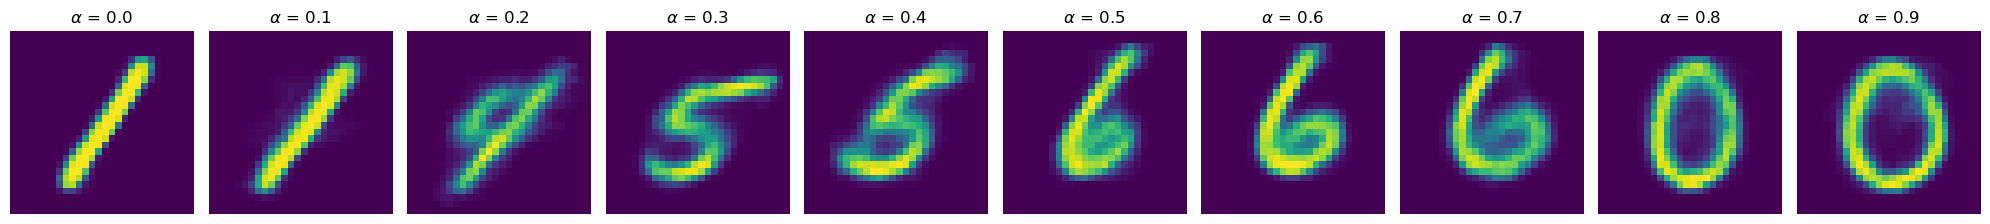

In [26]:
test.visualize_inter_class_interpolation(imgs, labels)

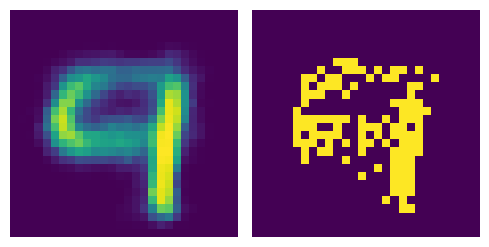

In [27]:
test.visualize_data_space(imgs[2])

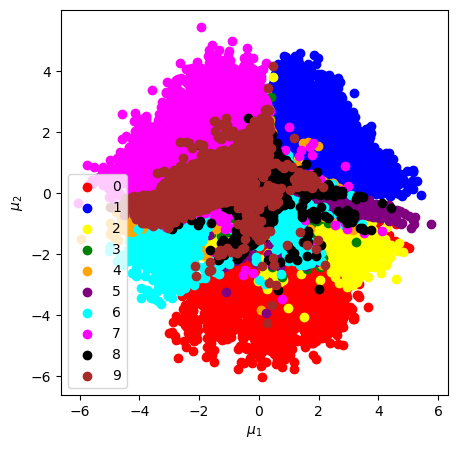

In [28]:
test.visualize_latent_space(imgs, labels)